In [119]:
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from arch import arch_model
from scipy import stats
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [120]:
def stock_data(stock_name):
    df = yf.download(stock_name, start="2010-01-01", end="2021-04-30")
    df['Return'] = df['Close'].pct_change().mul(100)
    df = df.dropna()
    train,test = df[df.index<'2021-01-01'],df[df.index>='2021-01-01']
    return train['Return'], test['Return']

In [121]:
train, test = stock_data('AAPL')

[*********************100%***********************]  1 of 1 completed


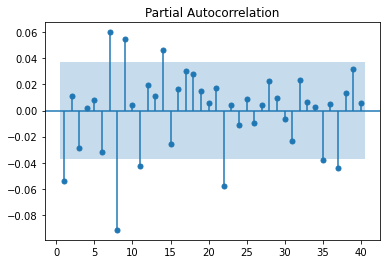

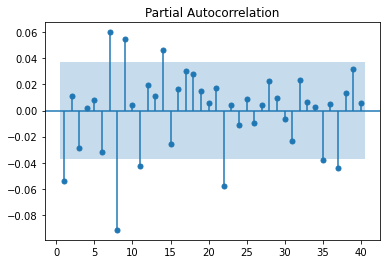

In [153]:
#Use partial autocorrelation to determine AR order
sgt.plot_pacf(train, zero = False, lags = 40)

In [172]:
def garch_model(train, num_of_predictions):
    data = pd.concat([train, test], axis=0)
    basic_gm = arch_model(data, p=1, q=1, mean='AR', #'ARX':
                          vol = 'GARCH', dist = 'normal')
    start_loc = 0
    end_loc = np.where(data.index >= test.index[0])[0].min()
    forecasts = {}
    for i in range(num_of_predictions):
        sys.stdout.write('.')
        sys.stdout.flush()
        res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
        temp = res.forecast(horizon=1).mean #mean or variance (residual variance)
        
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast
    rolling = pd.DataFrame(forecasts).T
    return rolling

In [173]:
predict = garch_model(train, len(test))['h.1'].values

.................................................................................

In [174]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluation(observation, forecast): 

    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,4)}')

    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,4)}')
    
    mape = mean_absolute_percentage_error(observation, forecast)
    print(f'Mean Absolute Percentage Error (MAPE): {round(mape,4)}')
    
    return mae, mape

In [175]:
evaluation(test, predict)

Mean Absolute Error (MAE): 1.5168
Mean Squared Error (MSE): 3.7334
Mean Absolute Percentage Error (MAPE): 1.0417


(1.5167663737970392, 1.0417192470560188)

## Visualization

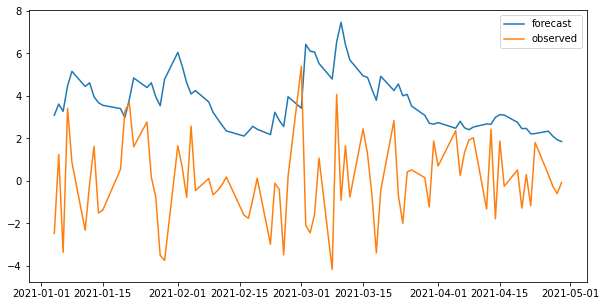

In [171]:
#Use the garch model to predict variance
plt.figure(figsize=(10,5))
plt.plot(list(test.index), predict, label='forecast')
plt.plot(list(test.index), test, label='observed')
plt.legend()
plt.show()

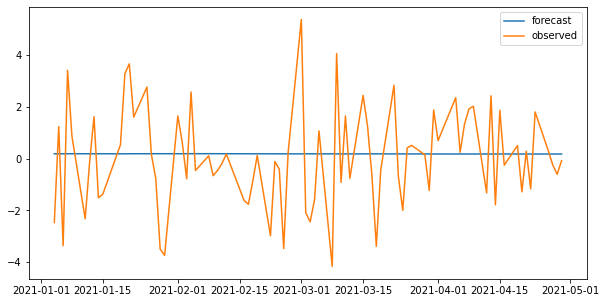

In [166]:
#Use the garch model to predict mean
plt.figure(figsize=(10,5))
plt.plot(list(test.index), predict, label='forecast')
plt.plot(list(test.index), test, label='observed')
plt.legend()
plt.show()

## Mean Model Prediction Using ARMA

In [190]:
import pmdarima as pm

model = pm.auto_arima(pd.concat([train, test], axis=0),
    d=0, # non-seasonal difference order
    start_p=1, # initial guess for p
    start_q=1, # initial guess for q
    max_p=4, # max value of p to test
    max_q=4, # max value of q to test                        

    seasonal=False, # is the time series seasonal

    information_criterion='bic', # used to select best model
    trace=True, # print results whilst training
    error_action='ignore', # ignore orders that don't work
    stepwise=True, # apply intelligent order search                     
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=11424.266, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=11416.739, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=11417.750, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=11417.959, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=11412.637, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=11412.337, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=11419.959, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=11419.241, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=11412.511, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=11427.169, Time=0.36 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.947 seconds


In [200]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=pd.concat([train, test]), order=(1, 0, 0))
_model_result = _arma_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00103D+00    |proj g|=  1.97375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   7.291D-06   2.001D+00
  F =   2.0010250701796606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [202]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='AR', p=1, q=1, vol = 'GARCH', dist = 'normal')
_garch_result = _garch_model.fit(last_obs=test.index[0],disp = 'off')
print(_garch_result.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5298.95
Distribution:                  Normal   AIC:                           10605.9
Method:            Maximum Likelihood   BIC:                           10629.6
                                        No. Observations:                 2768
Date:                Tue, Nov 23 2021   Df Residuals:                     2767
Time:                        02:06:37   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.1965  3.170e-02      6.196  5.774e-10 [  0.134,  0.25

In [203]:
forecasts = _garch_result.forecast(horizon=1)
fixed = forecasts.variance.dropna()[1:]
print(fixed)

                 h.1
Date                
2021-01-04  3.633899
2021-01-05  3.260568
2021-01-06  4.410487
2021-01-07  4.968678
2021-01-08  4.327320
...              ...
2021-04-23  2.273586
2021-04-26  2.051891
2021-04-27  1.890205
2021-04-28  1.819340
2021-04-29  1.689484

[81 rows x 1 columns]


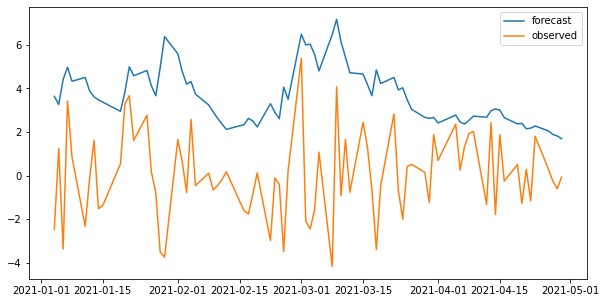

In [204]:
plt.figure(figsize=(10,5))
plt.plot(list(test.index), fixed, label='forecast')
plt.plot(list(test.index), test, label='observed')
plt.legend()
plt.show()

In [206]:
#evaluation(test, fixed)